Mount drive

In [1]:
#Mount Google Drive for accessing netflix data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import PReLU

Load Netflix Prize Data

In [3]:
df = pd.read_csv('drive/MyDrive/my_dataframe.csv')
df = df.sample(frac=0.25)

In [4]:
#Examine Df
df

,user,item,label
41620334,1459686,12500,3
48855701,2573577,14527,5
57386862,1869298,16552,3
1068593,2274813,331,3
1343685,955131,442,5
...,...,...,...
5690044,1333434,1905,5
55345852,2110121,16113,3
52168287,2476264,15124,5
8426898,688869,2699,2


In [5]:
df_movies = pd.read_csv('drive/MyDrive/movie_ids.csv')

In [6]:
def load_probe(file_path):
    """Load `probe.txt` or `qualifying.txt` into a DataFrame."""
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Ignore empty or non-data lines
            line = line.strip()
            if line.endswith(':'):  # Skip MovieID lines
                current_movie_id = int(line[:-1])
            else:
                # CustomerID, MovieID
                customer_id = int(line)
                data.append({'item': current_movie_id, 'user': customer_id})
    return pd.DataFrame(data)

In [7]:
probe_path = 'drive/MyDrive/netflix/probe.txt'
probe_df = load_probe(probe_path)

In [8]:
df_test = probe_df.merge(df, on=['item', 'user'], how='inner')

In [9]:
# Perform an anti-join to keep rows in df that are not in df_test
df_train = pd.merge(
    df,
    df_test,
    on=['user', 'item'],
    how='left',
    indicator=True
)

# Keep only rows that are present in df but not in df_test
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns='_merge')

df_train = df_train.rename(columns={'label_x': 'label'}).drop(columns=['label_y'], errors='ignore')

In [10]:
#Load the movie embedding dataframe
df_embed = pd.read_csv('drive/MyDrive/movie_embeddings.csv')

In [11]:
#View the dataframe
df_embed

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,id
0,0.022672,-0.046619,-0.264999,0.002058,-0.246339,0.163685,0.206668,0.470253,-0.429314,-0.087177,0.028014,0.725728,-0.409237,0.177025,0.181319,-0.484685,28
1,-0.034511,-0.150917,0.311247,0.553234,0.163956,0.117782,0.586246,-0.057972,-0.485735,-0.100956,0.098881,0.532428,-0.283507,-0.571461,-0.119147,-0.544009,30
2,-0.373251,0.107183,-0.379379,-0.019213,0.190449,0.074692,0.316270,-0.068675,-0.717374,-0.356092,-0.073990,-0.028135,0.041220,-0.710487,0.593704,-0.705546,111
3,-0.399297,-0.170430,0.014413,0.882139,-0.588318,0.063229,0.351257,0.009445,-0.456447,0.454165,-0.214734,-0.103632,-0.042765,0.302726,0.089273,-0.540521,143
4,0.209091,-0.266571,0.010041,0.499381,0.448013,0.728048,-0.077915,0.103958,-0.115441,0.369230,-0.596034,-0.498549,-0.255422,0.615441,0.546417,0.014236,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.096858,0.472940,-0.251432,0.043152,-0.183418,-0.159820,0.594324,0.288818,0.237473,0.027703,-0.344180,0.735708,-0.494132,0.631417,-0.123628,-0.439758,17627
966,-0.260978,0.139461,-0.695949,-0.716574,0.457376,-0.115717,0.125526,-0.015580,-0.489186,-0.421882,-0.041369,0.188164,-0.183041,-0.186893,0.420812,-0.863310,17692
967,0.374409,-0.062499,0.340542,0.824441,0.129979,0.071054,0.164043,0.483334,-0.488178,0.403280,-0.495424,0.334213,-0.072765,-0.021060,-0.157005,-0.397244,17709
968,-0.496976,0.176058,-0.059879,0.905965,-0.308712,0.193948,0.110646,0.281144,-0.255035,0.078165,-0.024952,0.137809,-0.001835,0.307531,-0.129833,-0.569351,17762


In [12]:
#Turn the embed df into a dictionary where the movie id points to the embedding vector
embed_dict = dict(zip(df_embed['id'], df_embed.drop('id', axis=1).values.astype(np.float32).tolist()))

# Display the result
print(embed_dict)

{28: [0.02267247624695301, -0.04661904647946358, -0.26499924063682556, 0.0020583539735525846, -0.24633868038654327, 0.16368484497070312, 0.20666813850402832, 0.4702528417110443, -0.4293135404586792, -0.0871765986084938, 0.02801373414695263, 0.7257281541824341, -0.40923750400543213, 0.17702503502368927, 0.18131913244724274, -0.4846847951412201], 30: [-0.03451063483953476, -0.1509171575307846, 0.31124743819236755, 0.5532339811325073, 0.16395647823810577, 0.1177816092967987, 0.5862462520599365, -0.05797198787331581, -0.4857349097728729, -0.10095598548650742, 0.09888086467981339, 0.5324276089668274, -0.28350675106048584, -0.571461021900177, -0.11914744973182678, -0.5440089702606201], 111: [-0.3732513189315796, 0.1071830466389656, -0.3793794512748718, -0.019213350489735603, 0.19044867157936096, 0.07469231635332108, 0.31626999378204346, -0.06867516040802002, -0.7173736095428467, -0.35609185695648193, -0.07399020344018936, -0.028135143220424652, 0.04121982306241989, -0.710486650466919, 0.5937

In [13]:
#Print some data info
print("Number of ALL samples:", len(df))
print("Number of train samples:", len(df_train))
print("Number of test samples:    ", len(df_test))

Number of ALL samples: 15446703
Number of train samples: 15241631
Number of test samples:     205072


In [14]:
#Find the average rating
global_avg = df_train['label'].mean()

print("Global average:", global_avg)

Global average: 3.687599378308004


In [15]:
#Add the norm label to the df
df_train['norm_label'] = df_train['label'] - global_avg
df_test['norm_label'] = df_test['label'] - global_avg

In [16]:
#Examine the train df
df_train.head()

,user,item,label,norm_label
0,1459686,12500,3,-0.687599
1,2573577,14527,5,1.312401
2,1869298,16552,3,-0.687599
3,2274813,331,3,-0.687599
4,955131,442,5,1.312401


In [17]:
#Examine the test df
df_test.head()

,item,user,label,norm_label
0,10027,2354884,5,1.312401
1,10027,748800,5,1.312401
2,10027,1050405,2,-1.687599
3,10027,825069,5,1.312401
4,10027,163607,5,1.312401


In [18]:
#Sort the movies df by id
df_movies = df_movies.sort_values(by=['id'])

In [19]:
df_movies.reset_index(drop=True, inplace=True)

In [20]:
df_movies.head()

,id
0,28
1,30
2,111
3,143
4,175


In [24]:
#This structure alone is like 10GB
user_to_items_ratings = df.groupby('user').apply(lambda group: list(zip(group['item'], group['label']))).to_dict()

<ipython-input-24-17bf5dc0f869>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_to_items_ratings = df.groupby('user').apply(lambda group: list(zip(group['item'], group['label']))).to_dict()


In [25]:
df_train

,user,item,label,norm_label
0,1459686,12500,3,-0.687599
1,2573577,14527,5,1.312401
2,1869298,16552,3,-0.687599
3,2274813,331,3,-0.687599
4,955131,442,5,1.312401
...,...,...,...,...
15446698,1333434,1905,5,1.312401
15446699,2110121,16113,3,-0.687599
15446700,2476264,15124,5,1.312401
15446701,688869,2699,2,-1.687599


In [26]:
df_test

,item,user,label,norm_label
0,10027,2354884,5,1.312401
1,10027,748800,5,1.312401
2,10027,1050405,2,-1.687599
3,10027,825069,5,1.312401
4,10027,163607,5,1.312401
...,...,...,...,...
205067,9960,1644385,5,1.312401
205068,9960,555962,1,-2.687599
205069,9960,1119187,5,1.312401
205070,9960,850878,3,-0.687599


In [27]:
df_train

,user,item,label,norm_label
0,1459686,12500,3,-0.687599
1,2573577,14527,5,1.312401
2,1869298,16552,3,-0.687599
3,2274813,331,3,-0.687599
4,955131,442,5,1.312401
...,...,...,...,...
15446698,1333434,1905,5,1.312401
15446699,2110121,16113,3,-0.687599
15446700,2476264,15124,5,1.312401
15446701,688869,2699,2,-1.687599


In [28]:
df_test

,item,user,label,norm_label
0,10027,2354884,5,1.312401
1,10027,748800,5,1.312401
2,10027,1050405,2,-1.687599
3,10027,825069,5,1.312401
4,10027,163607,5,1.312401
...,...,...,...,...
205067,9960,1644385,5,1.312401
205068,9960,555962,1,-2.687599
205069,9960,1119187,5,1.312401
205070,9960,850878,3,-0.687599


In [29]:
import random

UNORDERED_SEQ_LEN = 16

def getUserRep(user_id, item_id):
    all_items_ratings = user_to_items_ratings[user_id]
    item_ratings = [item for item in all_items_ratings if item[0] != item_id]

    rep = np.zeros((UNORDERED_SEQ_LEN, 16))

    if len(item_ratings) > UNORDERED_SEQ_LEN:
        item_ratings = random.sample(item_ratings, UNORDERED_SEQ_LEN)

    for i in range(len(item_ratings)):
        rep[i] = np.array(embed_dict[item_ratings[i][0]]).astype(np.float32) * (item_ratings[i][1] - global_avg).astype(np.float32)

    return rep

In [30]:
def getUserRepTest(user_id):
    item_ratings = user_to_items_ratings[user_id]

    rep = np.zeros((UNORDERED_SEQ_LEN, 16))

    if len(item_ratings) > UNORDERED_SEQ_LEN:
        item_ratings = random.sample(item_ratings, UNORDERED_SEQ_LEN)

    for i in range(len(item_ratings)):
        rep[i] = np.array(embed_dict[item_ratings[i][0]]).astype(np.float32) * (item_ratings[i][1] - global_avg).astype(np.float32)

    return rep

In [31]:
# Apply getUserRep to each user/item pair in df_train
train_user = np.stack([
    getUserRep(user, item)
    for user, item in zip(df_train['user'], df_train['item'])
]).astype(np.float32)
train_item = np.stack([embed_dict[item] for item in df_train['item']]).astype(np.float32)
train_label = df_train['norm_label'].values.astype(np.float32)

# Apply getUserRep to each user/item pair in df_train
test_user = np.stack([
    getUserRepTest(user)
    for user in df_test['user']
]).astype(np.float32)
test_item = np.stack([embed_dict[item] for item in df_test['item']]).astype(np.float32)
test_label = df_test['norm_label'].values.astype(np.float32)

In [32]:
dropout = 0.00
l2_reg = 0.000

In [41]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import PReLU

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dropout(dropout)(user_flat)
user_vec = layers.Dense(
    128,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_vec)



user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

In [42]:
model = keras.Model(
    inputs=[user_input, item_input],
    outputs=rating_prediction
)

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_embed_input          │ (None, 16, 16, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 16)     │            160 │ user_embed_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 7, 7, 16)       │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 5, 5, 256)      │         37,120 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 2, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1024)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1024)           │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        131,200 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 16)             │              0 │ item_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 16)             │              0 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 16)             │              0 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 16)             │          1,040 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 16)             │            272 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_user_item (Dot)       │ (None, 1)              │              0 │ dense_6[0][0],         │
│                      

 Total params: 178,050 (695.51 KB)

 Trainable params: 178,050 (695.51 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

print("Model compiled successfully.")

Model compiled successfully.


In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_rmse',       # or 'val_loss'
    mode='min',               # we want to minimize RMSE
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [47]:
batch_size = 1024
epochs = 4

history = model.fit(
    x=[train_user, train_item],
    y=train_label,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop],
    validation_split=0.2,
    #validation_data=([test_user, test_item], test_label),
    verbose=1
)

Epoch 1/4
11908/11908 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.8452 - rmse: 0.9193 - val_loss: 0.8179 - val_rmse: 0.9044
Epoch 2/4
11908/11908 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.8177 - rmse: 0.9043 - val_loss: 0.8153 - val_rmse: 0.9029
Epoch 3/4
11908/11908 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 0.8127 - rmse: 0.9015 - val_loss: 0.8119 - val_rmse: 0.9011
Epoch 4/4
11908/11908 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 0.8104 - rmse: 0.9002 - val_loss: 0.8114 - val_rmse: 0.9008
Restoring model weights from the end of the best epoch: 4.


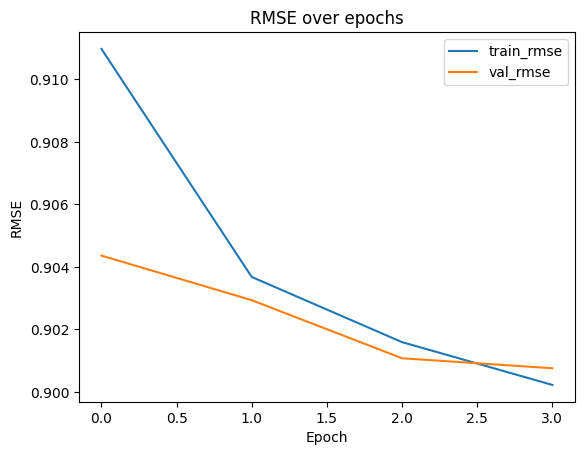

In [48]:
plt.plot(history.history['rmse'], label='train_rmse')
plt.plot(history.history['val_rmse'], label='val_rmse')
plt.title('RMSE over epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [50]:
predictions = model.predict([test_user, test_item])
mse = np.mean((predictions.flatten() - test_label)**2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

6409/6409 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
RMSE:  0.8673679


In [ ]:
error:

In [49]:
model.save("drive/MyDrive/deployment.keras")

In [ ]:
#df_test.to_csv('drive/MyDrive/test_data.csv', index=False)

In [ ]:
error:
from google.colab import runtime
runtime.unassign()


In [46]:
def reset_model_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            # Reinitialize kernel and bias if they exist
            old_kernel, old_bias = layer.get_weights()
            kernel_initializer = layer.kernel_initializer
            bias_initializer = layer.bias_initializer
            new_kernel = kernel_initializer(tf.shape(old_kernel))
            new_bias = bias_initializer(tf.shape(old_bias))
            layer.set_weights([new_kernel.numpy(), new_bias.numpy()])

# Example usage:
reset_model_weights(model)

0.9012 val

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import PReLU

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    256,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)



user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

0.902 val

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import PReLU

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    256,
    activation=PReLU(),
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)



user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation=PReLU(),
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation=PReLU(),
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation=PReLU(),
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

0.8570

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    256,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)



user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

0.8576

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    512,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)



user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    32,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

0.8636

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    512,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    128,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    32,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='leaky_relu',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)

0.8719: (Seq len 16)

In [ ]:
from tensorflow import keras
from tensrflow.keras import layers, regularizers

# Define the inputs
user_input = keras.Input(shape=(UNORDERED_SEQ_LEN,16,1), name='user_embed_input')
item_input = keras.Input(shape=(16,), name='item_input')

# USER TOWER

#conv_user = layers.Dropout(dropout)(user_input)

conv_user = tf.keras.layers.Conv2D(
    filters=16,           # For example, producing 16 feature maps
    kernel_size=(3, 3),   # 3 rows and 1 column; acts on each of the 16 columns independently.
    strides=(1, 1),
    padding='valid'
)(user_input)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

conv_user = tf.keras.layers.Conv2D(
    filters=256,            # Now combining the 16 channels into 8.
    kernel_size=(3, 3),   # Operate across 2 columns at a time.
    strides=(1, 1),       # This will reduce the width dimension by a factor of 2.
    padding='valid'
)(conv_user)

conv_user = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv_user)

user_flat = tf.keras.layers.Flatten()(conv_user)

#conv_user = layers.Dropout(dropout)(conv_user)

user_vec = layers.Dense(
    256,
    activation='sigmoid',
    kernel_regularizer=regularizers.l2(l2_reg)  # L2 regularization added here
)(user_flat)


user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    64,
    activation='sigmoid',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)

user_vec = layers.Dropout(dropout)(user_vec)
user_vec = layers.Dense(
    16,
    activation='sigmoid',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(user_vec)


# ITEM TOWER
item_flat = layers.Flatten()(item_input)

item_vec = layers.Dropout(dropout)(item_flat)


item_vec = layers.Dropout(dropout)(item_vec)
item_vec = layers.Dense(
    16,
    activation='sigmoid',
    kernel_regularizer=regularizers.l2(l2_reg)  # And here
)(item_vec)

# DOT PRODUCT of user and item towers
dot_user_item = layers.Dot(axes=1, normalize=False, name='dot_user_item')([user_vec, item_vec])

# Final prediction layer with regularization
rating_prediction = layers.Dense(
    1,
    activation='linear',
    name='rating_prediction',
    kernel_regularizer=regularizers.l2(l2_reg)  # Regularization added here as well
)(dot_user_item)